# Exploring Transformers by Experimenting with GPT-2

GPT-2 Small is a 124-million parameter transformer-based language model introduced by Radford et al. (2019) in "Language Models are Unsupervised Multitask Learners." Unlike the original transformer architecture (Vaswani et al., 2017), which was designed for sequence-to-sequence tasks with separate encoder and decoder, GPT-2 uses only a decoder-style architecture with causal attention masking for autoregressive text generation. GPT-2 Small consists of 12 transformer layers, each with 12 attention heads and a model dimensionality of 768.

GPT-2 is smaller and simpler than modern LLM's which makes it a convenient vehicle for getting a better understanding of transformer basics.

The goal of this lab is to gain a better understanding of the transformer architecture by experimenting with this relatively simple pre-trained transformer.

For the remainder of this lab, we will work with the `TransformerLab` class which provides a wrapper around the `GPT2LMHeadModel` provided by Huggingface. 

In [1]:
import transformer_lab
transformer = transformer_lab.TransformerLab()

Loading model: gpt2...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

done.


## Part 1 - Tokenization

GPT-2 uses **Byte Pair Encoding (BPE)** tokenization, which "learns" a tokenization by starting with characters and repeatedly merging the most frequent adjacent pairs of symbols to form larger tokens. This allows the model to represent common words as single tokens while still breaking rare or unknown words into smaller pieces. 

BPE tokenization is context-dependent—for example, a word at the beginning of a sentence may be tokenized differently than the same word appearing mid-sentence, as GPT-2's tokenizer treats leading spaces as part of the token.

Execute the following cell to observe how several different strings are tokenized:

In [2]:
# Example tokenizations
transformer.display_tokens("Happy birthday!")
transformer.display_tokens("birthday!")
transformer.display_tokens("The quick brown fox jumps over the lazy dog.")
transformer.display_tokens("My favorite word is supercalifragilisticexpialidocious")

----------------------------------------------------------------------
Input text: "Happy birthday!"
----------------------------------------------------------------------
Number of tokens: 3

Token breakdown:
  [ 0] Happy                (ID: 25082)
  [ 1] ' birthday'          (ID: 10955)
  [ 2] !                    (ID:     0)
----------------------------------------------------------------------
Input text: "birthday!"
----------------------------------------------------------------------
Number of tokens: 3

Token breakdown:
  [ 0] birth                (ID: 24280)
  [ 1] day                  (ID:   820)
  [ 2] !                    (ID:     0)
----------------------------------------------------------------------
Input text: "The quick brown fox jumps over the lazy dog."
----------------------------------------------------------------------
Number of tokens: 10

Token breakdown:
  [ 0] The                  (ID:   464)
  [ 1] ' quick'             (ID:  2068)
  [ 2] ' brown'           

### Questions
* Why is "birthday" represented using two tokens in the second example but not in the first example?

### Answers
* Because in the first, it's the end of the word, in the second it's in the middle.

## Part 2 - Autoregression

Before we take a closer look at how the various aspects of the transformer architecture work, let's try it out on a sequence generation task. Complete the code below to create a loop that generates the desired length of text from a starting prompt.

### Temperature Sampling

The `sample_next_token` method uses **temperature sampling** to control the randomness of predictions. Temperature modifies the logits (raw model outputs) before converting them to probabilities:

$$\text{logits}_{\text{scaled}} = \frac{\text{logits}}{\text{temperature}}$$

$$P(token_i) = \frac{e^{\text{logits}_{\text{scaled}}[i]}}{\sum_j e^{\text{logits}_{\text{scaled}}[j]}}$$

- **temperature = 1.0**: Uses the model's raw probability distribution (standard sampling)
- **temperature < 1.0** (e.g., 0.5): Makes the distribution more peaked → more deterministic, favors high-probability tokens
- **temperature > 1.0** (e.g., 1.5): Flattens the distribution → more random, gives lower-probability tokens more chance

Lower temperatures make the model more confident and repetitive; higher temperatures make it more creative but potentially incoherent.

In [14]:
text = "The cat sat on the"

# Example of generating a single token:
token_id, token_string = transformer.sample_next_token(text, temperature=1.0, greedy=False)
print(token_string)

# Now write a method to generate the desired number of tokens. 
# The return value should be a string consisting of the initial text 
# with each predicted word concatenated on the end.
def generate_text(prompt, predict_count, temperature=1.0, greedy=False):
    output = prompt
    while predict_count > 0:
        token_id, token_string = transformer.sample_next_token(output, temperature, greedy)
        output += token_string
        predict_count -= 1
    return output

print(generate_text(text, predict_count=20))

 base
The cat sat on theDisable Petrdamage landed amendment Kol Binding cultAnne AWShour装 reflected ADVTerror Lagasters fully Psy actionGroup


In [13]:
# Testing Code - Check that greedy generation produces expected output
test_prompt = "The cat sat on the"
result = generate_text(test_prompt, predict_count=5, temperature=1.0, greedy=True)

expected = "The cat sat on the floor, and the cat"
assert result == expected, f"Expected: '{expected}', but got: '{result}'"
print("Test passed!")

Test passed!


Once you have finished your implementation of `generate_text`, try it out by changing the initial text and generating multiple outputs at different temperature values.
### Questions
* Try generating some text with a temperature of 10.0. Try generating text with a temperature of 0.01. In each case, repeat the generation process several times with the same initial text. What do you observe?

### Answers
* Increasing temperature would make it more gibberish, decreasing the temperature made it more safe.

## Part 3 - Exploring Word Embeddings

GPT-2 small initially assigns random 768-dimensional embedding vectors to each token. These embedding vectors are treated as learnable parameters during training. Token embeddings end up organized so that their spatial distribution captures conceptual similarities between tokens: tokens with similar meanings tend to be near each other in the embedding space. The `visualize_word_embeddings` method takes a list of words, looks up their embeddings, uses PCA to project the embeddings to a two-dimensional space, then plots the resulting vectors.   

Populate the `all_words` list below with a list of 15-20 words that are divided into 3-4 clear conceptual categories.

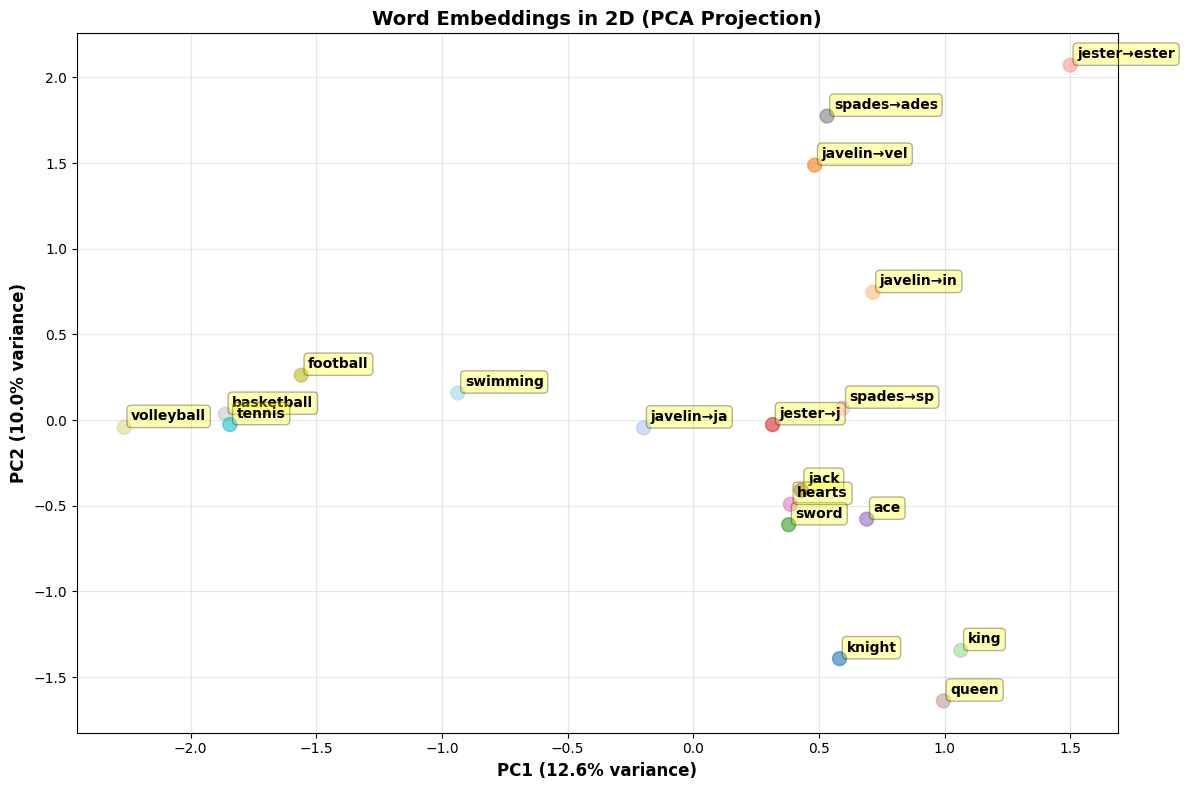

In [18]:
all_words = ["knight", "javelin", "sword", "king", "jester", "ace", "jack", "queen", "hearts", "spades", "basketball", "football", "volleyball", "tennis", "swimming"]
transformer.visualize_word_embeddings(all_words)

### Questions
* Do the spatial distributions correspond to your categories? 
* What happens when you include homonyms? For example, where does "orange" end up if your categories include fruits and colors?

### Answers
* For the most part, except for javelin and jester, because they were more uncommon words.
* It messed up sorting for both categories, and it just chose the medieval instead of playing cards.

## Part 4 - Exploring Attention

Let's take a look at some attention activations for the input text provided below. The attention for each token is in the corresponding row of the attention matrix.

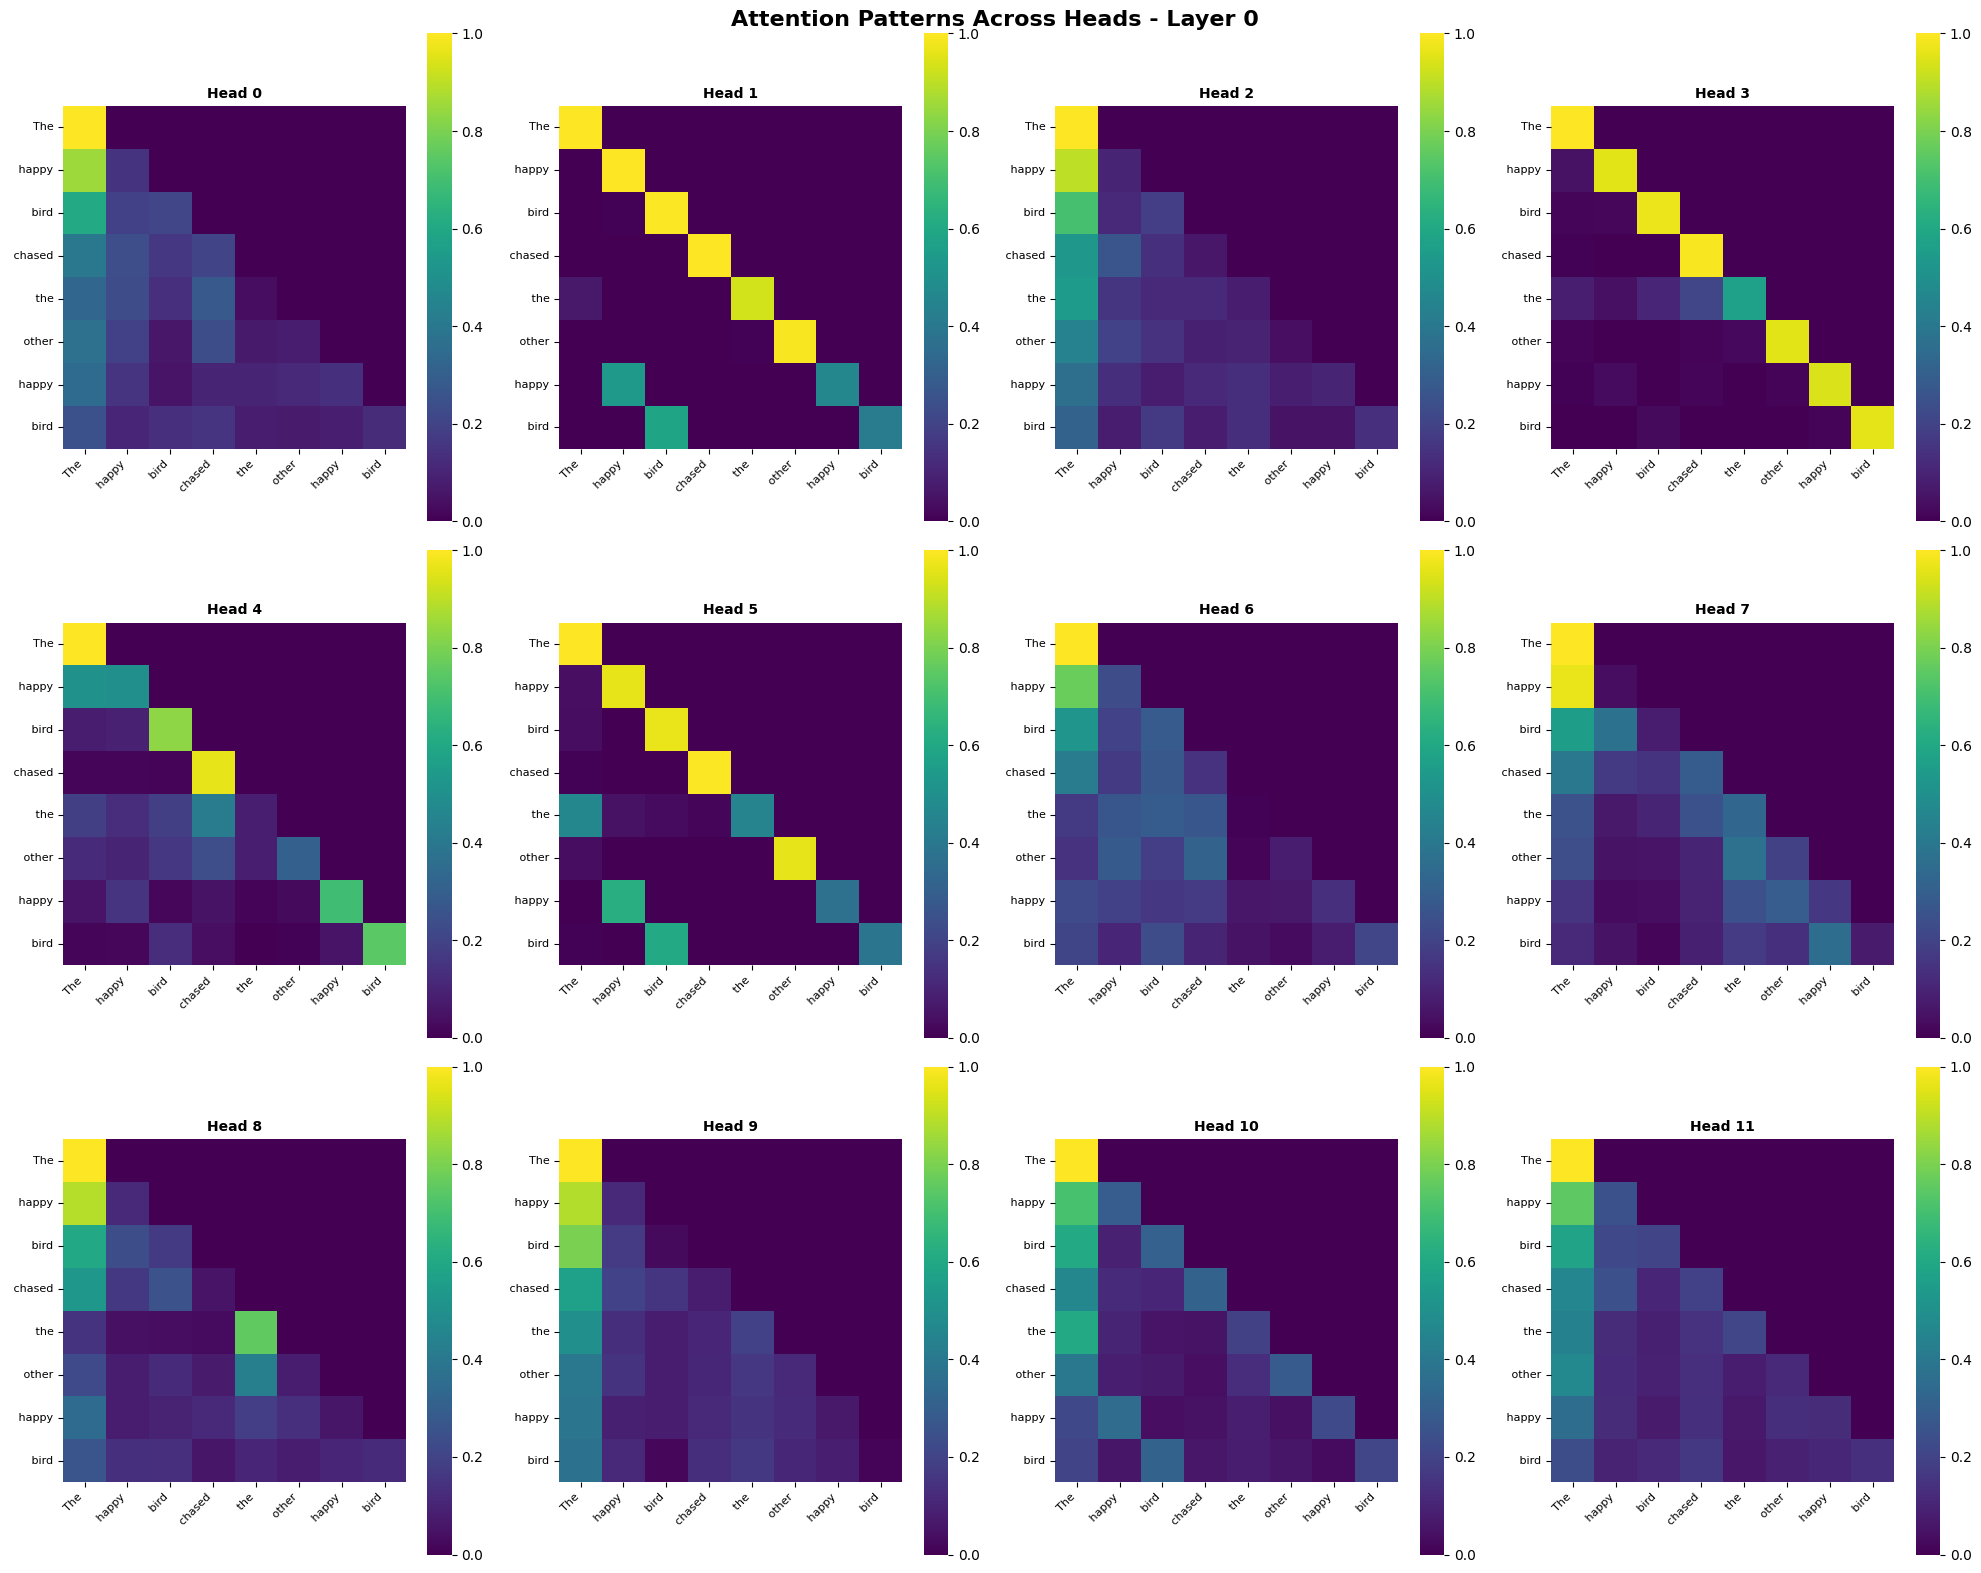

In [19]:
# Compute and visualize attention patterns
text = "The happy bird chased the other happy bird"
attention_patterns, token_info = transformer.compute_attention(text)

# Visualize all attention heads for layer 0 in a grid
transformer.visualize_attention_heads_grid(
    attention_patterns,
    token_info['tokens'],
    layer=0,
    max_heads=12
)

In general, it is difficult to assign specific roles to individual attention heads. This is a general challenge with large-scale neural networks: it is often difficult to interpret the computations that are being performed. That said, GPT-2 has some heads that behave in ways that are relatively easy to understand. The questions below will ask you to consider the general structure of the attention outputs and examine the behavior of some specific heads.

### Questions:
1. Notice that there is only one non-zero entry in the row associated with the token `The` while the final `bird` token has non-zero values in all entries. Explain why this is the case.
2. Look at the attention values for head `0.5` (layer 0, head 5). Describe how attention is allocated for the second `happy` token. How is attention allocated for the second `bird` token? Can you provide a general explanation for what this head is doing? Check your hypothesis by trying some different input sequences.
3. For this question we will denote the value vectors as $V_{i,j,k}$ and the output vectors as $O_{i,j,k}$ where $i$ is the token index, $j$ is the layer index, and $k$ is the head index. For the text "The happy bird chased the other happy bird", what is the approximate value of $O_{4, 0, 5}$ (indexing is 0-based, so this is the output for the second `the`)? Your answer should be provided as a weighted sum of the appropriate value vectors.
4. Take a look at the attention values for head `4.11`. Provide an English language description of how attention is allocated by this head.
5. How can head `4.11` do that? If the queries and keys are calculated from the word embeddings, how can we have an attention head that is clearly ignoring the word meanings and relying purely on word position?

<details>
  <summary>Click to show answer for Q5</summary>

GPT-2 adds **positional embeddings** to the word embeddings before feeding them into the transformer layers. These positional embeddings are learned 768-dimensional vectors (one for each position up to the maximum sequence length of 1024) that encode information about token position in the sequence.

When computing queries and keys, the attention mechanism has access to both semantic information (from word embeddings) and positional information (from positional embeddings). Through training, head 4.11's query and key projection matrices ($W_Q$ and $W_K$) have learned to amplify the positional components while suppressing the semantic components. This allows it to compute attention patterns that depend primarily on relative position rather than word meaning.

In essence, the learned $W_Q$ and $W_K$ matrices act as filters that extract and emphasize the positional features from the combined word+position embeddings, enabling position-based attention patterns.

</details>

### Answers
1. Because the is the is the first token, it cannot see the future so it shouldn't be able to attend the future and use it as input, meaning no prediction.
2. This model also gives attention to previous copies of the same token.
3. 
4.
5. (In your own words.)

## Part 5 - Exploring Attention Calculation

Here is a quick overview of the process by which attention is calculated for a particular head:

Let $X$ be the input sequence of token representations with shape $(T, d_{\text{model}})$.

For a particular attention head $h$, GPT-2 uses learned projection parameters:

$W_Q^{(h)} \in \mathbb{R}^{d_{\text{model}} \times d_{\text{head}}}, \quad b_Q^{(h)} \in \mathbb{R}^{d_{\text{head}}}$  
$W_K^{(h)} \in \mathbb{R}^{d_{\text{model}} \times d_{\text{head}}}, \quad b_K^{(h)} \in \mathbb{R}^{d_{\text{head}}}$  
$W_V^{(h)} \in \mathbb{R}^{d_{\text{model}} \times d_{\text{head}}}, \quad b_V^{(h)} \in \mathbb{R}^{d_{\text{head}}}$

Queries, keys, and values:

$Q^{(h)} = X W_Q^{(h)} + \mathbf{1}_T \, {b_Q^{(h)}}^{\top}$  
$K^{(h)} = X W_K^{(h)} + \mathbf{1}_T \, {b_K^{(h)}}^{\top}$  
$V^{(h)} = X W_V^{(h)} + \mathbf{1}_T \, {b_V^{(h)}}^{\top}$

Here $\mathbf{1}_T$ is a length-$T$ column vector of ones so the bias broadcasts over all positions.

Attention scores (before softmax):

$S^{(h)} = \frac{Q^{(h)} {K^{(h)}}^{\top}}{\sqrt{d_{\text{head}}}}$

Causal mask (all values above the diagonal are set to $-\infty$):

$S^{(h)}_{i,j} =
\begin{cases}
S^{(h)}_{i,j} & j \le i \\
-\infty & j > i
\end{cases}$

Attention weights (softmax is calculated across the rows):

$A^{(h)} = \text{softmax}(S^{(h)})$

### Questions
1. Given that $d_{\text{head}}$ is 64 and $d_{\text{model}}$ is 768, what is the shape of $Q^{(h)}$ for a sequence of length 10?
2. What is the shape of ${K^{(h)}}^{\top}$ for a sequence of length 10?
3. What is the shape of $S^{(h)}$ for a sequence of length 10?
4. Recall that the softmax function can be expressed as: $\frac{e^{z_i}}{\sum_{j} e^{z_j}}$. With this in mind, why does it make sense to set the attention values above the diagonal to $-\infty$?

### Answers
1. 
2. 
3. 
4.

## Part 6 - Calculating Attention in PyTorch

Complete the unfinished method below for computing attention for one head.

Notes: 
* The bias broadcasting will happen automatically in PyTorch. You don't need to handle it manually with a vector of ones.
* Given the score logits, you can set the upper-diagonal values to $-\infty$ as follows:

In [ ]:
import torch
def compute_attention(
    embeddings: torch.Tensor,
    W_Q: torch.Tensor,
    W_K: torch.Tensor,
    b_Q: torch.Tensor,
    b_K: torch.Tensor
) -> torch.Tensor:
    """
    Calculate scaled dot product attention given input embeddings and weights.

    Args:
        embeddings: [seq_len, d_model] - Input embeddings (layer-normalized)
        W_Q: [d_model, d_head] - Query weight matrix
        W_K: [d_model, d_head] - Key weight matrix
        b_Q: [d_head] - Query bias
        b_K: [d_head] - Key bias
        
    Returns:
        attention_pattern: [seq_len, seq_len] - Attention probability distribution
                            (softmax probabilities showing how much each position
                            attends to every other position)
    """
    d_head = W_Q.shape[1]
    seq_len = embeddings.shape[0]
    
    

Now let's test your implementation by comparing it to GPT-2's actual attention computation for a specific head.

In [ ]:
# Test text
test_text = "The cat sat on the mat"

# Choose a specific layer and head to test
layer = 0
head = 5

# Get the attention patterns and token info from GPT-2
attention_patterns, token_info = transformer.compute_attention(test_text)
gpt2_attention = attention_patterns[layer, head].cpu()  # [seq_len, seq_len]

# Get the layer-normalized embeddings for the test text
embeddings = transformer.get_input_embeddings(test_text, apply_layer_norm=True)

# Get the Q and K projection weights for this specific head
W_Q, W_K, W_V, b_Q, b_K, b_V = transformer.get_attention_head_weights(layer, head)

# Compute attention using your implementation
student_attention = compute_attention(embeddings, W_Q, W_K, b_Q, b_K)

# Compare the results
difference = torch.abs(student_attention - gpt2_attention)
max_diff = difference.max().item()
mean_diff = difference.mean().item()

print(f"Comparison Results:")
print(f"  Maximum difference: {max_diff:.10f}")
print(f"  Mean difference: {mean_diff:.10f}")

if max_diff < 1e-5:
    print("\nEXCELLENT! Your implementation matches GPT-2's attention!")
else:
    print("\nWarning: Significant differences detected. Check your implementation.")

In [ ]:
# Visualize your implementation
print("Your Implementation:")
transformer.visualize_attention(student_attention, token_info['tokens'], figsize=(8, 6))

# Visualize GPT-2's actual attention
print(f"\nGPT-2 Actual Attention (Layer {layer}, Head {head}):")
transformer.visualize_attention(gpt2_attention, token_info['tokens'], figsize=(8, 6))

print("\nNote: If your implementation is correct, both heatmaps should look identical!")